### Imports

In [1]:
import liesel.model as lsl
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
import liesel.goose as gs
import numpy as np
import pandas as pd
import plotnine as p9
from scipy.special import expit
from jax.scipy.special import logit
import matplotlib.pyplot as plt

### Generating data

In [2]:
n = 1000
np.random.seed(2*130525 - 130525)

# par
beta = np.array([-1, -1])
gamma = np.array([-0.5, -2])
nu = np.array([-0.5, -2])

# matrices
X = np.column_stack((np.ones(n), np.random.uniform(size=(n, 1))))
Z = X.copy()
S = X.copy()

# predictor for the conditional mean
pred_mu = X @ beta
mu = expit(pred_mu) # conditional mean

# predictor for log(p0/p2)
pred_p0p2 = Z @ gamma

# predictor for log(p1/p2)
pred_p1p2 = S @ nu

# probabilities of zero and one
p0p2 = np.exp(pred_p0p2)
p1p2 = np.exp(pred_p1p2)
den = 1 + p0p2 + p1p2
p0, p1 = p0p2 / den, p1p2 / den

phi = 40

y_cont = np.random.beta(mu * phi, (1 - mu) * phi, size=n)
is_inflated = np.random.binomial(1, p0 + p1)
p_one_given_infl = np.divide(p1, p0 + p1, out=np.zeros_like(p1), where=p0 + p1>0)

is_one = np.zeros(n, dtype=int)
idx = np.where(is_inflated == 1)[0]
is_one[idx] = np.random.binomial(1, p_one_given_infl[idx])

y = np.where(is_inflated == 1, is_one, y_cont)

#data frame
data = pd.DataFrame(np.column_stack([y, X, Z, S]),
                    columns=["y", "X0", "X1", "Z0", "Z1", "S0", "S1"])
X_cont = X[(data['y'] != 0) & (data['y'] != 1) ]

### Setup response model

In [3]:
# Response variable
yvar = lsl.Var.new_obs(y, name="y")

#### Continuous part

In [4]:
X = lsl.Var.new_obs(X_cont, name="X")

continuous_indicator = (y > 0.0) & (y < 1.0) # we only use the values in (0,1) to estimate the parameters of the continuous part

# parameter
beta = lsl.Var.new_param(
    value=np.array([0.0, 0.0]), 
    distribution=lsl.Dist(tfd.Normal, 
                          loc=0.0, 
                          scale=lsl.Var.new_value(100.0, name="$\\sigma_{\\beta}$")),
    name="$\\beta$",
    inference=gs.MCMCSpec(gs.NUTSKernel)
)

# predictor of the conditional mean
eta_mu = lsl.Var(lsl.Calc(jnp.dot, X, beta), name="$\\eta_{\\mu}$")

# conditional mean
mu = lsl.Var(
    lsl.Calc(lambda eta: jax.nn.sigmoid(eta), eta=eta_mu),
    name="$\\mu$"
)

# conditional precision
phi = lsl.Var.new_param(
    1.0, 
    distribution = lsl.Dist(tfd.Gamma, concentration=0.001, rate=0.001),
    name="$\\phi$")
phi_transformed = phi.transform(tfb.Exp(), inference=gs.MCMCSpec(gs.IWLSKernel), name="$\\log \\phi$")

# parameters of the beta distribution in tensorflow parameterization
shape1 = lsl.Calc(lambda mu, phi: (mu * phi).astype(jnp.float32), mu=mu, phi=phi)
shape2 = lsl.Calc(lambda mu, phi: ((1 - mu) * phi).astype(jnp.float32), mu=mu, phi=phi)

# Using lsl.Calc to obtain the continuous response and set up the distribution of its continuous part
y_continuous_calc = lsl.Calc(
    lambda y: jnp.asarray(y[(y > 0.0) & (y < 1.0)], dtype=jnp.float32),
    y=yvar
)
y_cont = lsl.Var(
    y_continuous_calc,
    distribution=lsl.Dist(tfd.Beta, 
                          concentration1=shape1, 
                          concentration0=shape2),
    name="$y \\in (0, 1)$",
)

#### Discrete part

In [5]:
Z = lsl.Var.new_obs(Z, name="Z")
S = lsl.Var.new_obs(S, name="S")

# Parameters for the discrete part submodels
gamma = lsl.Var.new_param(
    value=np.array([0.0, 0.0]), 
    distribution=lsl.Dist(tfd.Normal, 
                          loc=0.0, 
                          scale=lsl.Var.new_value(100.0, name="$\\sigma_{\\gamma}$")),
    name="$\\gamma$",
    inference=gs.MCMCSpec(gs.NUTSKernel)
)

tau = lsl.Var.new_param(
    value=np.array([0.0, 0.0]), 
    distribution=lsl.Dist(tfd.Normal, 
                          loc=0.0, 
                          scale=lsl.Var.new_value(100.0, name="$\\sigma_{\\tau}$")),
    name="$\\tau$",
    inference=gs.MCMCSpec(gs.NUTSKernel)
)

# predictor of the discrete part submodels
eta_p0p2 = lsl.Var(lsl.Calc(jnp.dot, Z, gamma), name="$\\eta_{p_0p_2}$")
eta_p1p2 = lsl.Var(lsl.Calc(jnp.dot, S, tau), name="$\\eta_{p_1p_2}$")

# parameter of the multinomial distribution in tensorflow 
logits = lsl.Calc(lambda eta0, eta1: jnp.stack([eta0, eta1, jnp.zeros_like(eta0)], axis=-1),
                  eta0=eta_p0p2, eta1=eta_p1p2)

# Using lsl.Calc to obtain the discrete response and set up the distribution of its discrete part
dichotomized_calc = lsl.Calc(
      lambda y: jax.nn.one_hot(
          jnp.where(y == 0.0, 0,
                    jnp.where(y == 1.0, 1, 2)), 
          num_classes=3
      ).astype(jnp.float32),
      y=yvar
)
y_dichotomized = lsl.Var(
    dichotomized_calc,
    distribution=lsl.Dist(
        tfd.Multinomial, 
        total_count=jnp.array(1, dtype=jnp.float32), 
        logits=logits
    ),
    name="$\\left(I_{\\{0\\}}(y), I_{\\{1\\}}(y), I_{(0,1)}(y)\\right)$",
)


In [6]:
model = lsl.Model([y_dichotomized, y_cont])

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value
liesel.model.model - INFO - Converted dtype of Value(name="$\beta$_value").value
liesel.model.model - INFO - Converted dtype of Value(name="X_value").value
liesel.model.model - INFO - Converted dtype of Value(name="$\tau$_value").value
liesel.model.model - INFO - Converted dtype of Value(name="S_value").value
liesel.model.model - INFO - Converted dtype of Value(name="$\gamma$_value").value
liesel.model.model - INFO - Converted dtype of Value(name="Z_value").value


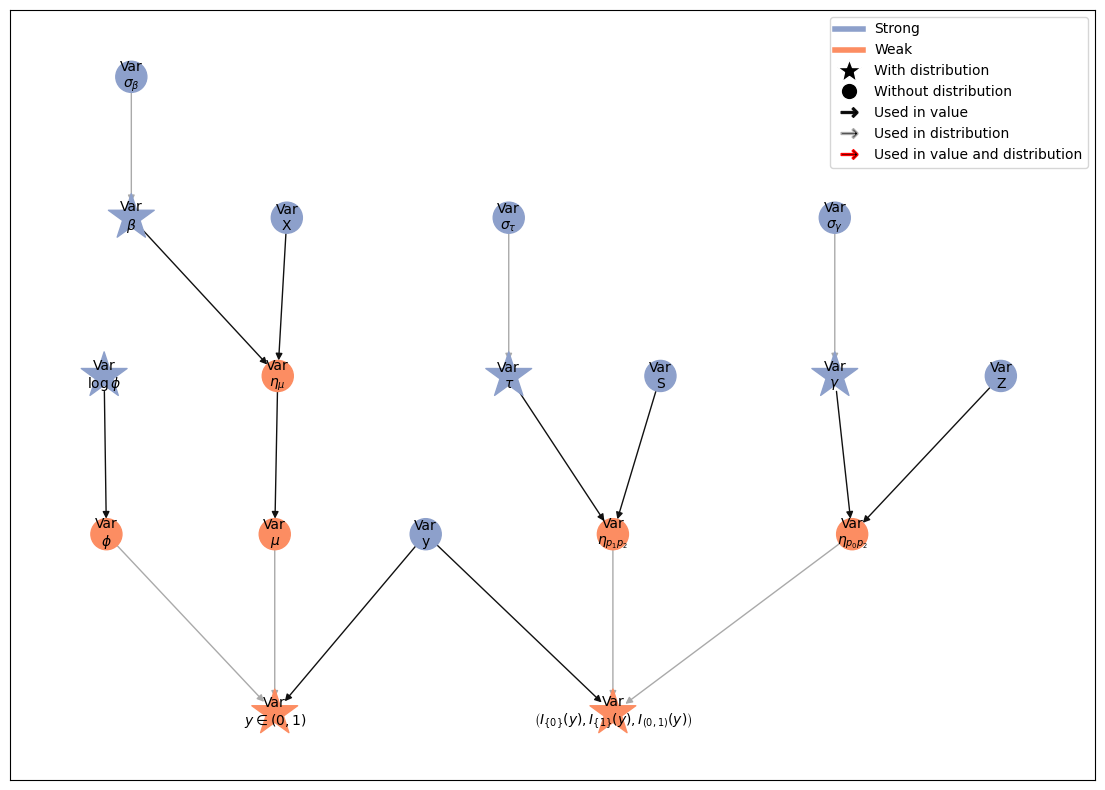

In [7]:
model.plot_vars()

### Run MCMC

In [ ]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\log \\phi$', '$\\beta$', '$\\tau$', '$\\gamma$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:13<00:00,  1.23chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 4, 5, 5, 2 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 4, 6, 3, 2 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 1, 5, 4, 2 / 400 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1006.07chunk/s]
liesel.goose.engine - WARNING - Errors per chain

In [ ]:
gs.Summary(results)

In [ ]:
summary = gs.Summary(results)
gs.plot_trace(results)

### Predictions

In [ ]:
samples = results.get_posterior_samples()

In [ ]:
# matrices
X_new = np.column_stack((np.ones(100), np.linspace(data["X1"].min(), data["X1"].max(), 100, dtype=np.float32)))
Z_new = X_new.copy()
S_new = X_new.copy()

new_data = {
    "X": X_new,
    "Z": Z_new,
    "S": S_new
}
predictions = model.predict(  
    samples=samples,
    predict=["$\\mu$", "$\\eta_{p_0p_2}$", "$\\eta_{p_1p_2}$"],
    newdata=new_data,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  
predictions_summary["x"] = np.tile(X_new[:, 1] , len(predictions))

In [ ]:
true_mu = expit(X_new @ np.array([-1, -1])) 
X1_values = X_new[:, 1]  

df_true_mu = pd.DataFrame({
    "X1": X1_values, 
    "mu_true": true_mu
})

In [ ]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("X1", "y"), data=data, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.geom_line(p9.aes("X1", "mu_true"), data=df_true_mu, color="red", linetype="dashed")
    + p9.guides(fill="none")
)